In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

import rasterio
from rasterio.features import shapes

import matplotlib.patches as mpatches
#from shapely.geometry import Point, Polygon, shape
from matplotlib.path import Path
import laspy
import open3d as o3d

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


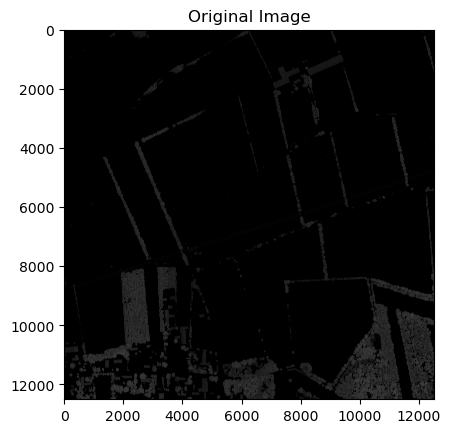

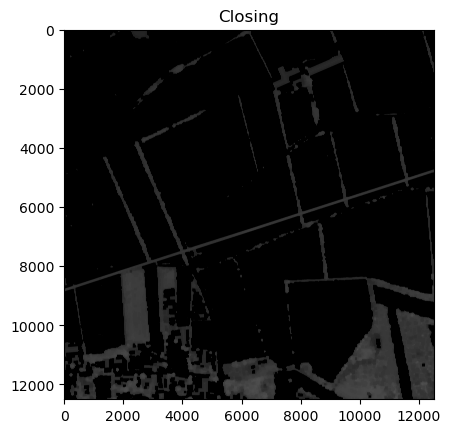

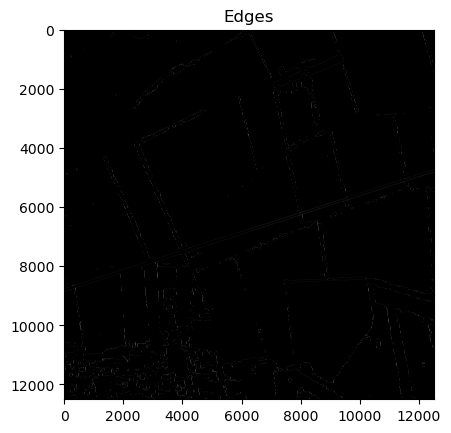

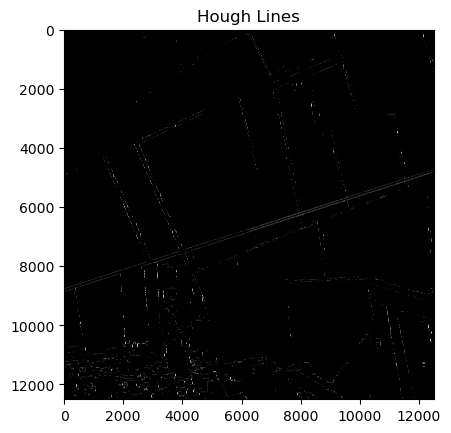

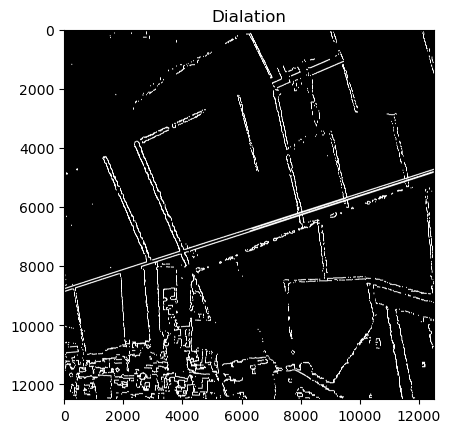

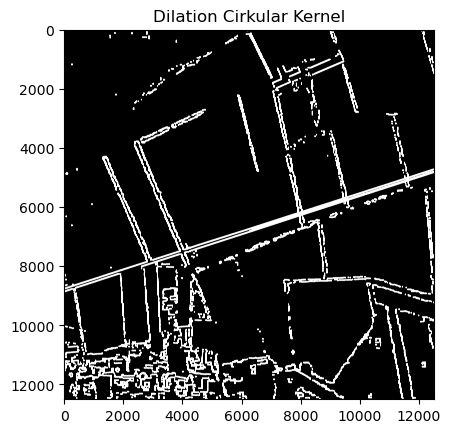

In [2]:
image = cv2.imread('/home/frederik/data/TestData/meters_idw.tif', cv2.IMREAD_UNCHANGED)
image = np.where(image >= 0, image, 0)
image = image/np.max(image)

image = (image*255).astype(np.uint8)
plt.title("Original Image")
plt.imshow(image, cmap='gray')
plt.show()

kernel = np.ones((70,70),np.uint8)
closing = cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)

plt.title("Closing")
plt.imshow(closing, cmap='gray')
plt.show()

# Apply edge detection method on the image
edges = cv2.Canny(closing, 4, 160, None, 3)

plt.title("Edges")
plt.imshow(edges, cmap='gray')
plt.show()

# Probabilistic Line Transform
# min_line_length, max_line_gap

linesP = cv2.HoughLinesP(edges, 1, np.pi / 180, 100)

lines_image = np.zeros_like(image)
# Draw the lines
if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(lines_image, (l[0], l[1]), (l[2], l[3]), (255,0,0), 3)

plt.title("Hough Lines")
plt.imshow(lines_image, cmap='gray')
plt.show()

kernel = np.ones((5,5),np.uint8)
dilation = cv2.dilate(lines_image, kernel, iterations = 7)
plt.imshow(dilation, cmap='gray')
plt.title("Dialation")
plt.show()


# Pixels per kilometer
x_pixels, y_pixels = image.shape

# Pixels per meter
x_pixels, y_pixels = x_pixels/1000, y_pixels/1000

# Set kernel size to 1 meter around the each line
kernel_size = int(2*np.ceil(x_pixels))

# Create kernel
circular_kernel = np.zeros((kernel_size, kernel_size), np.uint8)

# Create a cirkular kernel using (image, center_coordinates, radius, color, thickness)
cv2.circle(circular_kernel, (int(kernel_size/2), int(kernel_size/2)), int(kernel_size/2), 255, -1)

# Perform dilation with the cirkular kernel
dilation_cirkular_kernel = cv2.dilate(dilation, circular_kernel, iterations=1)

plt.title("Dilation Cirkular Kernel")
plt.imshow(dilation_cirkular_kernel, cmap="gray")
plt.show()

In [3]:
# gdal_polygonize -f gpkg small_area.tif small.gpkg

In [4]:
mask = (dilation_cirkular_kernel == 255)
output = rasterio.features.shapes(dilation_cirkular_kernel, mask=mask, connectivity=4)
multipolygons_list = list(output)
print("Amount of multipolygons: ", len(multipolygons_list))

polygons_unpacked = []
for multi_polygons in multipolygons_list:
    for polygon in multi_polygons[0]['coordinates']:
        polygons_unpacked.append(Path(polygon))

print("Amount of polygons: ", len(polygons_unpacked))

Amount of multipolygons:  437
Amount of polygons:  547


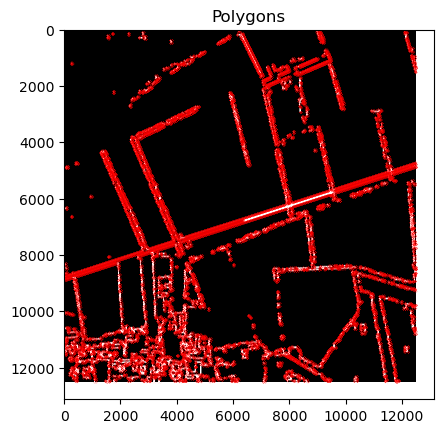

In [5]:
plt.figure()
plt.imshow(dilation_cirkular_kernel, cmap='gray')

for i in polygons_unpacked:
    x = i.vertices[:,0]
    y = i.vertices[:,1]
    plt.scatter(x,y, s=0.001, color='red')
    
plt.title("Polygons")
plt.show()

In [6]:
# Pixels per kilometer
x_pixels, y_pixels = image.shape

def MaxMinNormalize(arr):
    return (arr - np.min(arr))/(np.max(arr)-np.min(arr))

def CastAllXValuesToImage(arr, x_pixels):
    return MaxMinNormalize(arr)*x_pixels

def CastAllYValuesToImage(arr, y_pixels):
    return (1-MaxMinNormalize(arr))*y_pixels

In [7]:
las = laspy.read(r'/home/frederik/data/denmark/raw/train/PUNKTSKY_00005_1km_6090_503.laz')
list(las.point_format.dimension_names)

4095


['X',
 'Y',
 'Z',
 'intensity',
 'return_number',
 'number_of_returns',
 'synthetic',
 'key_point',
 'withheld',
 'overlap',
 'scanner_channel',
 'scan_direction_flag',
 'edge_of_flight_line',
 'classification',
 'user_data',
 'scan_angle',
 'point_source_id',
 'gps_time',
 'red',
 'green',
 'blue',
 'ClassFlags',
 'Amplitude',
 'Reflectance',
 'Deviation']

In [8]:
x_values = CastAllXValuesToImage(las.X, x_pixels)
y_values = CastAllXValuesToImage(las.Y, x_pixels)

# Format: [(1,1), (3,5), (1,5)]
list_zipped = list(zip(x_values, y_values))

indexes_needed = np.zeros(len(x_values), dtype=bool)

#for j in polygons_unpacked:
#    points_found = j.contains_points(list_zipped)
#    indexes_needed = indexes_needed | gg

In [3]:
point_data = np.stack([las.X, las.Y], axis=0).transpose((1, 0))

In [10]:
list_zipped

[(339.40215, 12162.84795),
 (335.40183, 12161.84787),
 (330.90147, 12160.72278),
 (326.52612, 12159.59769),
 (341.52732000000003, 12167.47332),
 (337.15197, 12166.47324),
 (333.02664, 12165.47316),
 (328.52628000000004, 12164.34807),
 (324.40095, 12163.34799),
 (319.77558, 12162.2229),
 (315.77526, 12161.22282),
 (311.64993, 12160.222740000001),
 (307.02456, 12159.09765),
 (341.02727999999996, 12172.47372),
 (336.90195, 12171.47364),
 (332.90163, 12170.47356),
 (328.52628000000004, 12169.47348),
 (324.15093, 12168.34839),
 (319.90059, 12167.34831),
 (315.77526, 12166.34823),
 (311.39991000000003, 12165.22314),
 (307.14957000000004, 12164.22306),
 (303.02424, 12163.222979999999),
 (298.39887, 12162.097890000001),
 (294.52356000000003, 12161.09781),
 (290.39823, 12160.09773),
 (285.77286, 12158.97264),
 (341.02727999999996, 12177.2241),
 (336.90195, 12176.22402),
 (332.65161, 12175.22394),
 (328.15125, 12174.09885),
 (324.02592, 12173.09877),
 (319.77558, 12171.97368),
 (315.77526, 12171

In [ ]:

#point_data = np.stack([las.X, las.Y, las.Z], axis=0).transpose((1, 0))

#geom = o3d.geometry.PointCloud()
#geom.points = o3d.utility.Vector3dVector(point_data)
#o3d.visualization.draw_geometries([geom])